## **Install Catboost, Mount Google Drive, and Import libraries**

In [ ]:
#@title ✅ Install libraries
%pip install catboost > /dev/null 2>&1
%pip install --upgrade scikit-learn > /dev/null 2>&1

In [ ]:
# -------------------------------------------------------------------
#@title ✅ Initialize Environment: Mount Drive, Suppress Warnings, & Load Modules
# -------------------------------------------------------------------
# Standard Library Imports
import os
import re
import json
import joblib
import warnings

# Third-party Library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from scipy.stats import zscore # For calculating Z-scores

# Google Colab Specific Imports
from google.colab import drive, userdata

# Machine Learning Imports - Scikit-learn
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, f1_score, log_loss
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RandomizedSearchCV,
    GridSearchCV,
    cross_validate
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight

# Machine Learning Imports - Other Libraries
import shap
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Configuration/Setup
# Ignore all FutureWarnings globally
warnings.simplefilter(action='ignore', category=FutureWarning)

print("FutureWarnings are now ignored.")
drive.mount('/content/drive')

FutureWarnings are now ignored.
Mounted at /content/drive


## **Load and Read Data**

In [ ]:
# --------------------------------------------------------------
#@title ✅ Load and read data, and first 5 rows of a DataFrame.
# --------------------------------------------------------------

# Specify the base directory where your data files are located in Google Drive
data_dir = '/content/drive/MyDrive/HIV-Exp-Project/Data'

# Define the full path to the CSV file you want to read
csv_filename = "balanced.csv"
file_path_to_read = os.path.join(data_dir, csv_filename)

# Read the data from the specified CSV file
df = pd.read_csv(file_path_to_read)

print("\nFirst 5 rows of df:")
df.head()


First 5 rows of df:


,EnumID,State,Age,Gender,Marital Status,Family Setting,Num of Children,Educational Status,Employment Status,Monthly Income,...,Meds_Explained_SideFX,Encourage_Questions,Respond_Q_Concerns,Showed_Personal_Concern,Involved_In_Decisions,Discuss_NextSteps,Checked_Understanding,Time_Spent_Adequate,Visit_Satisfaction,Source
0,SYNTH-NEU-628,Bauchi,25-34,Female,Single,Monogamy,3-4,Primary education,Self-employed,"101,000–200,000 Naira",...,Agree,Agree,Agree,Neither Agree or Disagree,Agree,Neither Agree or Disagree,Strongly Agree,Agree,Neutral,Synthetic
1,SYNTH-SAT-154,Kano,55 years and above,Female,Single,Monogamy,Greater than 4,No formal education,Self-employed,"51,000–100,000 Naira",...,Strongly Agree,Agree,Agree,Disagree,Strongly Agree,Agree,Agree,Agree,Satisfied,Synthetic
2,BC023,Bauchi,35–44,Female,Married,Monogamy,1-2,Secondary education,Unemployed,Prefer not to say,...,Agree,Agree,Disagree,Disagree,Strongly Agree,Strongly Agree,Strongly Agree,Agree,Very satisfied,Original
3,KN27,Kano,55 years and above,Female,Divorced,Monogamy,Greater than 4,No formal education,Unemployed,Prefer not to say,...,Strongly Agree,Disagree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Very satisfied,Original
4,BC023,Bauchi,35–44,Male,Married,Monogamy,3-4,Secondary education,Other (please specify),"51,000–100,000 Naira",...,Agree,Neither Agree or Disagree,Agree,Agree,Agree,Strongly Agree,Agree,Agree,Very satisfied,Original


In [ ]:
# -----------------------------------------------------------
#@title ✅ Overview of the DataFrame's structure and content.
# -----------------------------------------------------------
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1501 entries, 0 to 1500
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   EnumID                    1501 non-null   object
 1   State                     1501 non-null   object
 2   Age                       1501 non-null   object
 3   Gender                    1501 non-null   object
 4   Marital Status            1501 non-null   object
 5   Family Setting            1501 non-null   object
 6   Num of Children           1501 non-null   object
 7   Educational Status        1501 non-null   object
 8   Employment Status         1501 non-null   object
 9   Monthly Income            1501 non-null   object
 10  Treatment Regimen         1501 non-null   object
 11  HIV_Duration_Years        1501 non-null   object
 12  Care_Duration_Years       1501 non-null   object
 13  Facility_Care_Dur_Years   1501 non-null   object
 14  HIV_Diag_Type           

## **Data Preprocessing**

### *   **Transformation of Continuous Variables (Currently Categorical Ranges)**




In [ ]:
#------------------------------------------
#@title ✅ 1. Transform 'Age'
#------------------------------------------

age_mapping = {
    '18–24': 21,
    '25-34': 29.5,
    '35–44': 39.5,
    '45–54': 49.5,
    '55 years and above': 65 # Estimating 65 as a reasonable midpoint for an open-ended "above 55"
}
df['Age'] = df['Age'].replace(age_mapping).astype(float) # Convert to float

print("--- Transformed 'Age' ---")
print(df['Age'].unique())
#print(df[['Age']].head())
#print("-" * 30)

--- Transformed 'Age' ---
[29.5 65.  39.5 21.  49.5]


In [ ]:
#------------------------------------------
#@title ✅ 2. Transform 'Num of Children'
#------------------------------------------

children_mapping = {
    '1-2': 1.5,
    '3-4': 3.5,
    'Greater than 4': 5 # Estimating 5 as a reasonable value for "Greater than 4"
}
df['Num of Children'] = df['Num of Children'].replace(children_mapping).astype(float)

print("--- Transformed 'Num of Children' ---")
print(df['Num of Children'].unique())
#print(df[['Num of Children']].head())
#print("-" * 30)

--- Transformed 'Num of Children' ---
[3.5 5.  1.5]


In [ ]:
#------------------------------------------
#@title ✅ 3. Transform 'Monthly Income'
#------------------------------------------

income_mapping = {
    'Less than 20,000 Naira': 10000,
    '20,000–50,000 Naira': 35000,
    '51,000–100,000 Naira': 75500,
    '101,000–200,000 Naira': 150500,
    'More than 200,000 Naira': 250000, # Estimating 250,000 as a reasonable value
    'Prefer not to say': np.nan # Map 'Prefer not to say' to NaN
}
df['Monthly Income'] = df['Monthly Income'].replace(income_mapping).astype(float)

print("--- Transformed 'Monthly Income' ---")
print(df['Monthly Income'].unique())
#print(df[['Monthly Income']].head())
#print("-" * 30)

--- Transformed 'Monthly Income' ---
[150500.  75500.     nan  10000.  35000. 250000.]


In [ ]:
#--------------------------------------------------------------------------------------------------------------
#@title Fill the missing data points in Monthly Income with Imputation with a Missing Indicator (using Median)
#--------------------------------------------------------------------------------------------------------------

# Create the missing indicator column
df['Monthly_Income_Missing'] = df['Monthly Income'].isna().astype(int)

# Then, fill the NaNs in the original column using median imputation
median_income = df['Monthly Income'].median()
df['Monthly Income'].fillna(median_income, inplace=True)

print("Monthly Income after imputation and adding missing indicator:")
print(df[['Monthly Income', 'Monthly_Income_Missing']].sample())
print("\nValue counts for Monthly_Income_Missing:")
print(df['Monthly_Income_Missing'].value_counts())
print("\nValue counts for Monthly_Income:")
print(df['Monthly Income'].value_counts())

Monthly Income after imputation and adding missing indicator:
      Monthly Income  Monthly_Income_Missing
1328         75500.0                       0

Value counts for Monthly_Income_Missing:
Monthly_Income_Missing
0    1319
1     182
Name: count, dtype: int64

Value counts for Monthly_Income:
Monthly Income
10000.0     874
75500.0     275
35000.0     240
150500.0    100
250000.0     12
Name: count, dtype: int64


In [ ]:
#----------------------------------------------------------------------------------------------------------
#@title ✅ 4. Transform Duration Columns (HIV_Duration_Years, Care_Duration_Years, Facility_Care_Dur_Years)
#-----------------------------------------------------------------------------------------------------------

# Note: Pay attention to different hyphens (en-dash vs. hyphen)
duration_mapping = {
    'Less than 1 year': 0.5,
    '1-3 years': 2,
    '1–3 years': 2, # Handle en-dash variation
    '4-7 years': 5.5,
    '4–7 years': 5.5, # Handle en-dash variation
    '8-10 years': 9,
    '8–10 years': 9, # Handle en-dash variation
    'More than 10 years': 12.5 # Estimating 12.5 as a reasonable value
}

for col in ['HIV_Duration_Years', 'Care_Duration_Years', 'Facility_Care_Dur_Years']:
    df[col] = df[col].replace(duration_mapping).astype(float)
    print(f"------Transformed---'{col}'------")
    print(df[col].unique())
    #print(df[[col]].head())
    #print("-" * 30)

------Transformed---'HIV_Duration_Years'------
[12.5  2.   5.5  9.   0.5]
------Transformed---'Care_Duration_Years'------
[ 2.   0.5 12.5  5.5  9. ]
------Transformed---'Facility_Care_Dur_Years'------
[ 5.5 12.5  2.   9.   0.5]



### *  **Identify outlier with Z-score and treat the identified outlier with Log Transformation**



In [ ]:
#----------------------------------------------
#@title ✅ 1. Identify outlier with Z-score
#----------------------------------------------

# List of continuous numerical columns to process
continuous_cols = [
    'Age',
    'Num of Children',
    'Monthly Income',
    'HIV_Duration_Years',
    'Care_Duration_Years',
    'Facility_Care_Dur_Years'
]

# --- Outlier Identification using Z-score ---
# This loop both IDENTIFIES and POPULATES the list of outlier columns.
# It MUST be run before the log transformation loop.
cols_with_outliers_for_transform = []
print("--- Outlier Identification (Z-score) ---")
for col in continuous_cols:
    df[f'{col}_zscore'] = np.abs(zscore(df[col]))
    outliers = df[df[f'{col}_zscore'] > 3]
    print(f"Column: '{col}'")
    if not outliers.empty:
        print(f"  {len(outliers)} potential outlier(s) with |Z-score| > 3:")
        print(outliers[[col, f'{col}_zscore']])
        cols_with_outliers_for_transform.append(col)
    else:
        print(f"  No potential outliers found with |Z-score| > 3 for '{col}'.")
    print("-" * 80)

print(f"\nColumns identified for log transformation (with outliers): {cols_with_outliers_for_transform}")
print("\n" + "="*80 + "\n")

--- Outlier Identification (Z-score) ---
Column: 'Age'
  No potential outliers found with |Z-score| > 3 for 'Age'.
--------------------------------------------------------------------------------
Column: 'Num of Children'
  No potential outliers found with |Z-score| > 3 for 'Num of Children'.
--------------------------------------------------------------------------------
Column: 'Monthly Income'
  12 potential outlier(s) with |Z-score| > 3:
      Monthly Income  Monthly Income_zscore
58          250000.0               4.857804
206         250000.0               4.857804
231         250000.0               4.857804
337         250000.0               4.857804
379         250000.0               4.857804
888         250000.0               4.857804
906         250000.0               4.857804
1001        250000.0               4.857804
1037        250000.0               4.857804
1202        250000.0               4.857804
1377        250000.0               4.857804
1448        250000.0      

In [ ]:
#---------------------------------------------------------------------
#@title ✅ 2. Treat the identified outlier with Log Transformation
#---------------------------------------------------------------------

# --- Outlier Treatment with Log Transformation (Conditional) ---
# This loop depends on the list created above.
print("--- Applying Log Transformation (np.log1p) to identified outlier columns ---")
transformed_cols_display = []
for col in continuous_cols:
    if col in cols_with_outliers_for_transform: # The variable must be defined by now
        df[f'{col}_log'] = np.log1p(df[col])
        print(f"'{col}' transformed to '{col}_log' (due to outliers).")
        transformed_cols_display.append(col)
    else:
        print(f"'{col}' not transformed (no significant outliers detected).")
print("\n" + "="*80 + "\n")

--- Applying Log Transformation (np.log1p) to identified outlier columns ---
'Age' not transformed (no significant outliers detected).
'Num of Children' not transformed (no significant outliers detected).
'Monthly Income' transformed to 'Monthly Income_log' (due to outliers).
'HIV_Duration_Years' not transformed (no significant outliers detected).
'Care_Duration_Years' not transformed (no significant outliers detected).
'Facility_Care_Dur_Years' not transformed (no significant outliers detected).




In [ ]:
#-----------------------------------------
#@title ✅ DataFrame display and overview
#-----------------------------------------
display_cols_final = []
for col in continuous_cols:
    display_cols_final.append(col)
    display_cols_final.append(f'{col}_zscore')
    if col in transformed_cols_display:
        display_cols_final.append(f'{col}_log')

print("\n--- Final DataFrame head with original, Z-score, and conditionally log-transformed columns ---")
print(df[display_cols_final].head())

print("\nDataFrame Info (check dtypes and new columns):")
df.info()


--- Final DataFrame head with original, Z-score, and conditionally log-transformed columns ---
    Age  Age_zscore  Num of Children  Num of Children_zscore  Monthly Income  \
0  29.5    0.723740              3.5                0.045697        150500.0   
1  65.0    2.519594              5.0                1.123054         75500.0   
2  39.5    0.189875              1.5                1.390778         10000.0   
3  65.0    2.519594              5.0                1.123054         10000.0   
4  39.5    0.189875              3.5                0.045697         75500.0   

   Monthly Income_zscore  Monthly Income_log  HIV_Duration_Years  \
0               2.585595           11.921725                12.5   
1               0.872875           11.231901                12.5   
2               0.622901            9.210440                12.5   
3               0.622901            9.210440                 2.0   
4               0.872875           11.231901                 5.5   

   HIV_Duratio


### *  **Standardize Likert Columns, Check for Misspellings, and Unexpected Categories
**



In [ ]:
#-----------------------------------------
#@title ✅ 1.  Define Likert columns
#-----------------------------------------

likert_columns = [
       'Greet_Comfort', 'Discuss_VisitReason', 'Encourage_Thoughts',
       'Listen_Careful', 'Understood_You', 'Exam_Explained',
       'LabTests_Explained', 'Discuss_TreatOptions', 'Info_AsDesired',
       'Plan_Acceptability_Check', 'Meds_Explained_SideFX',
       'Encourage_Questions', 'Respond_Q_Concerns', 'Showed_Personal_Concern',
       'Involved_In_Decisions', 'Discuss_NextSteps', 'Checked_Understanding',
       'Time_Spent_Adequate', 'Visit_Satisfaction'
]

In [ ]:
#------------------------------------------------------
#@title ✅ 2. Strip whitespace and standardize casing
#------------------------------------------------------

for col in likert_columns:
    df[col] = df[col].astype(str).str.strip().str.title()

In [ ]:
#----------------------------------------------------------------
#@title ✅ 3. Check unique values post-cleanup with dotted lines
#----------------------------------------------------------------

for col in likert_columns:
    print(f"{col}: {df[col].unique()}")
    print("-" * 90) # Prints a dotted line

Greet_Comfort: ['Agree' 'Strongly Agree' 'Strongly Disagree' 'Disagree'
 'Neither Agree Or Disagree']
------------------------------------------------------------------------------------------
Discuss_VisitReason: ['Strongly Disagree' 'Strongly Agree' 'Agree' 'Neither Agree Or Disagree'
 'Disagree']
------------------------------------------------------------------------------------------
Encourage_Thoughts: ['Agree' 'Neither Agree Or Disagree' 'Strongly Agree' 'Disagree']
------------------------------------------------------------------------------------------
Listen_Careful: ['Agree' 'Strongly Agree' 'Disagree' 'Neither Agree Or Disagree']
------------------------------------------------------------------------------------------
Understood_You: ['Agree' 'Disagree' 'Strongly Agree' 'Neither Agree Or Disagree'
 'Strongly Disagree']
------------------------------------------------------------------------------------------
Exam_Explained: ['Agree' 'Strongly Agree' 'Disagree' 'Neither Ag

In [ ]:
#-----------------------------------------
#@title ✅ 4. Quick Frequency Check
#-----------------------------------------
for col in likert_columns:
    print(f"\n{col} value counts:")
    print(df[col].value_counts(dropna=False))
    print("-" * 40)


Greet_Comfort value counts:
Greet_Comfort
Strongly Agree               786
Agree                        584
Strongly Disagree            106
Neither Agree Or Disagree     14
Disagree                      11
Name: count, dtype: int64
----------------------------------------

Discuss_VisitReason value counts:
Discuss_VisitReason
Strongly Agree               758
Agree                        636
Strongly Disagree             51
Neither Agree Or Disagree     35
Disagree                      21
Name: count, dtype: int64
----------------------------------------

Encourage_Thoughts value counts:
Encourage_Thoughts
Strongly Agree               903
Agree                        511
Neither Agree Or Disagree     72
Disagree                      15
Name: count, dtype: int64
----------------------------------------

Listen_Careful value counts:
Listen_Careful
Agree                        783
Strongly Agree               674
Neither Agree Or Disagree     26
Disagree                      18
Name: cou

## **Feature Engineering**

### 1.  **Grouped Categorical Variables**

In [ ]:
#-----------------------------------------
#@title ✅ Educational Level Grouping
#-----------------------------------------

education_map = {
    'No formal education': 'No formal',
    'Primary education': 'Primary/Secondary',
    'Secondary education': 'Primary/Secondary',
    'Tertiary education (e.g., University, college)': 'Tertiary+',
    'Postgraduate': 'Tertiary+', # If this value exists in your raw data but not unique(), keep it.
    'Islamic education': 'No formal', # Or group as appropriate
    'Diploma': 'Tertiary+', # Or group as appropriate
    'Adult and non formal education': 'No formal' # Or group as appropriate
}

df['Education_Grouped'] = df['Educational Status'].map(education_map)

# Now, this should show your grouped categories and potentially NaN if any new unmapped values appear
print(df['Education_Grouped'].unique())

['Primary/Secondary' 'No formal' 'Tertiary+']


In [ ]:
#-----------------------------------------
#@title ✅ Employment Grouping
#-----------------------------------------

employment_map = {
    'Unemployed': 'Unemployed',
    'Self-employed': 'Informal',
    'Employed part-time': 'Formal',  # Assuming part-time employment is formal
    'Employed full-time': 'Formal',  # Assuming full-time employment is formal
    'Other (please specify)': 'Other', # Grouping 'Other (please specify)' into 'Other'
    'Retired': 'Other',
    # If 'Informal', 'Government', 'Private', 'Student' don't exist in your raw 'Employment Status' column,
    # you can remove them from the map, or keep them if they might appear in other data.
    # For now, let's include only the ones found in your unique list.
}

df['Employment_Grouped'] = df['Employment Status'].map(employment_map)

# Now, this should show your grouped categories without NaN (unless there are new unmapped values)
print(df['Employment_Grouped'].unique())

['Informal' 'Unemployed' 'Other' 'Formal']


In [ ]:
#-----------------------------------------
#@title ✅ Marital Grouping
#-----------------------------------------

marital_map = {
    'Single': 'Single',
    'Married': 'Married',
    'Divorced': 'Separated/Widowed',
    'Widowed': 'Separated/Widowed',
    'Seperated': 'Separated/Widowed' # Corrected spelling and mapping for your unique value
}

df['Marital_Grouped'] = df['Marital Status'].map(marital_map)

# This should now show your grouped categories without NaN (unless new unmapped values appear)
print(df['Marital_Grouped'].unique())

['Single' 'Married' 'Separated/Widowed']



### 2.  **Derive Duration and Interactive Features**

In [ ]:
#--------------------------------------------------------------
#@title ✅ Duration Features Derivatives and Interaction Terms
#--------------------------------------------------------------

df['HIV_Care_Duration_Ratio'] = df['HIV_Duration_Years'] / (df['Care_Duration_Years'] + 0.1)

# Bucket Care Duration
df['Care_Duration_Bucket'] = pd.cut(df['Care_Duration_Years'],
                                     bins=[-np.inf, 1, 4, np.inf],
                                     labels=['Short-term', 'Medium-term', 'Long-term'])

# Interaction Terms
df['Age_x_HIV_Duration'] = df['Age'] * df['HIV_Duration_Years']
df['Income_x_Education'] = df['Monthly Income'].fillna(0) * df['Educational Status'].astype('category').cat.codes
df['Gender_x_Employment'] = df['Gender'].astype(
    'category').cat.codes * df['Employment Status'].astype('category').cat.codes
df['Education_x_Employment'] = df['Educational Status'].astype(
    'category').cat.codes * df['Employment Status'].astype('category').cat.codes

### 3. **Build Subscores for Likert-style Columns**

In [ ]:
# -----------------------------------------
#@title ✅ 1. Define your Likert-style columns
# -----------------------------------------

empathy_cols = [
    'Showed_Personal_Concern',
    'Greet_Comfort',
    'Respond_Q_Concerns',
    'Time_Spent_Adequate'
]

listening_cols = [
    'Encourage_Thoughts',
    'Listen_Careful',
    'Understood_You'
]

decision_share_cols = [
    'Involved_In_Decisions',
    'Checked_Understanding',
    'Encourage_Questions'
]

info_delivery_cols = [
    'Discuss_VisitReason',
    'Exam_Explained',
    'LabTests_Explained',
    'Discuss_TreatOptions',
    'Meds_Explained_SideFX',
    'Info_AsDesired',
    'Plan_Acceptability_Check',
    'Discuss_NextSteps'
]

# Combine all columns
all_subscore_columns = empathy_cols + listening_cols + decision_share_cols + info_delivery_cols
# ----------------------------------------------------------------------------------------------

In [ ]:
# -----------------------------------------
#@title ✅ 2. Robust Likert Cleaner
# -----------------------------------------

def normalize_likert(val):
    if pd.isnull(val):
        return None
    val = str(val).strip().lower()
    # Corrected: Match against lowercase strings
    if "strongly agree" in val:
        return 5
    elif val == "agree":
        return 4
    elif val == "neither agree or disagree":
        return 3
    elif "strongly disagree" in val: # Corrected: match against full phrase
        return 1
    elif "disagree" in val: # This should catch "Disagree" but not "Strongly Disagree" due to order
        return 2
    else:
        return None

# -----------------------------------------
# Apply cleaning to relevant columns
# -----------------------------------------

for col in all_subscore_columns:
    if col in df.columns:
        df[col] = df[col].apply(normalize_likert)

In [ ]:
# -----------------------------------------
#@title ✅ 3. Build subscores
# -----------------------------------------
df['Empathy_Score'] = df[empathy_cols].mean(axis=1)
df['Listening_Score'] = df[listening_cols].mean(axis=1)
df['Decision_Share_Score'] = df[decision_share_cols].mean(axis=1)
df['Info_Delivery_Score'] = df[info_delivery_cols].mean(axis=1)

# -----------------------------------------
# Check missing values in subscores
# -----------------------------------------

missing_subscores = df[[
    'Empathy_Score',
    'Listening_Score',
    'Decision_Share_Score',
    'Info_Delivery_Score'
]].isnull().sum()

print("Missing values in subscores:\n", missing_subscores)

# See how many total rows are affected
rows_missing = df[[
    'Empathy_Score',
    'Listening_Score',
    'Decision_Share_Score',
    'Info_Delivery_Score'
]].isnull().any(axis=1).sum()

print(f"\nTotal rows with at least one missing subscore: {rows_missing}")

Missing values in subscores:
 Empathy_Score           0
Listening_Score         0
Decision_Share_Score    0
Info_Delivery_Score     0
dtype: int64

Total rows with at least one missing subscore: 0


### 4. **Subscores Interaction Features**

In [ ]:
# -----------------------------------------
#@title ✅  Interaction Features
# -----------------------------------------

# Using .loc for explicit assignment
df.loc[:, "Empathy_Listening_Interaction"] = df["Empathy_Score"] * df["Listening_Score"]
df.loc[:, "Empathy_DecisionShare_Interaction"] = df["Empathy_Score"] * df["Decision_Share_Score"]

### 5. **Aggregate Behavioral Profiles**

In [ ]:
# --------------------------------------------------------------------
#@title ✅ Aggregate Behavioral Profiles
# All_High_Satisfaction: whether all Likert items were 4 or 5.
# Any_Dissatisfaction: whether any of the core variables are below 3.
# -------------------------------------------------------------------

core_likert = ['Empathy_Score', 'Listening_Score',
               'Decision_Share_Score', 'Info_Delivery_Score']
df["All_High_Satisfaction"] = (df[core_likert] >= 4).all(axis=1).astype(int)
df["Any_Low_Score"] = (df[core_likert] < 3).any(axis=1).astype(int)

### 6. **Check for Duplicate Patients, and Treat Accordingly**

In [ ]:
# -----------------------------------------
#@title ✅ 1. Check for duplicate patients
# -----------------------------------------

# Check if 'EnumID' column exists
if 'EnumID' in df.columns:
    # Create a temporary DataFrame by dropping 'EnumID' for the duplicate check
    df_for_dup_check = df.drop(columns=['EnumID'])
else:
    # If 'EnumID' doesn't exist, use the entire DataFrame
    df_for_dup_check = df.copy()

## Step 1: Identify Duplicate Rows
print("## Identifying Duplicate Rows")
# 'keep=False' marks all occurrences of a duplicate set as True
dupes_found = df_for_dup_check[df_for_dup_check.duplicated(keep=False)]

if not dupes_found.empty:
    print(f"**Duplicate rows found (considering all columns EXCEPT 'EnumID'): {len(dupes_found)}**")
    print("Here are the full rows from your original DataFrame that are considered duplicates:")
    # Use the index from 'dupes_found' to select corresponding rows from the original 'df'
    print(df.loc[dupes_found.index])
else:
    print("**No duplicate rows found (excluding 'EnumID').**")

#-----------------------------------
## Step 2: Drop Duplicates
#-----------------------------------

# Drop duplicates based on all columns EXCEPT 'EnumID'
# 'keep='first'' will keep the first occurrence of each duplicate set
if 'EnumID' in df.columns:
    # Get columns to consider for dropping duplicates (all except 'EnumID')
    columns_to_consider = [col for col in df.columns if col != 'EnumID']
    df_cleaned = df.drop_duplicates(subset=columns_to_consider, keep='first')
else:
    # If 'EnumID' doesn't exist, drop duplicates based on all columns
    df_cleaned = df.drop_duplicates(keep='first')

print("\n## DataFrame after dropping duplicates:")
print(f"Original DataFrame shape: {df.shape}")
print(f"Cleaned DataFrame shape: {df_cleaned.shape}")
print(df_cleaned)

## Identifying Duplicate Rows
**Duplicate rows found (considering all columns EXCEPT 'EnumID'): 4**
Here are the full rows from your original DataFrame that are considered duplicates:
             EnumID   State   Age  Gender Marital Status Family Setting  \
80    SYNTH-VER-904  Bauchi  21.0  Female        Married       Monogamy   
305            KN17    Kano  29.5  Female        Married       Monogamy   
709           KN 17    Kano  29.5  Female        Married       Monogamy   
1499  SYNTH-VER-970  Bauchi  21.0  Female        Married       Monogamy   

      Num of Children   Educational Status Employment Status  Monthly Income  \
80                3.5    Primary education     Self-employed         10000.0   
305               3.5  No formal education     Self-employed         35000.0   
709               3.5  No formal education     Self-employed         35000.0   
1499              3.5    Primary education     Self-employed         10000.0   

      ... Gender_x_Employment  Educatio

In [ ]:
#@title ✅ Rename the Column: 'Satisfaction' for 'Visit_Satisfaction'

df_cleaned.rename(columns={'Visit_Satisfaction': 'Satisfaction'}, inplace=True)

df_cleaned.columns

/tmp/ipython-input-27-930711103.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.rename(columns={'Visit_Satisfaction': 'Satisfaction'}, inplace=True)


Index(['EnumID', 'State', 'Age', 'Gender', 'Marital Status', 'Family Setting',
       'Num of Children', 'Educational Status', 'Employment Status',
       'Monthly Income', 'Treatment Regimen', 'HIV_Duration_Years',
       'Care_Duration_Years', 'Facility_Care_Dur_Years', 'HIV_Diag_Type',
       'Greet_Comfort', 'Discuss_VisitReason', 'Encourage_Thoughts',
       'Listen_Careful', 'Understood_You', 'Exam_Explained',
       'LabTests_Explained', 'Discuss_TreatOptions', 'Info_AsDesired',
       'Plan_Acceptability_Check', 'Meds_Explained_SideFX',
       'Encourage_Questions', 'Respond_Q_Concerns', 'Showed_Personal_Concern',
       'Involved_In_Decisions', 'Discuss_NextSteps', 'Checked_Understanding',
       'Time_Spent_Adequate', 'Satisfaction', 'Source',
       'Monthly_Income_Missing', 'Age_zscore', 'Num of Children_zscore',
       'Monthly Income_zscore', 'HIV_Duration_Years_zscore',
       'Care_Duration_Years_zscore', 'Facility_Care_Dur_Years_zscore',
       'Monthly Income_log', 'E

In [ ]:
# ---------------------------------------------------
#@title ✅ Remove Redundant Features to Reduce Noise
# ---------------------------------------------------

# List of features to drop
features_to_drop = [
    'EnumID', 'Source', 'Visit_Satisfaction', 'Monthly_Income_Missing',
    'Age_zscore', 'Num of Children_zscore', 'Monthly Income_zscore','HIV_Duration_Years_zscore',
    'Care_Duration_Years_zscore', 'Facility_Care_Dur_Years_zscore','Educational Status', 'Employment Status',
    'Marital Status','Monthly Income', 'Care_Duration_Bucket','Income_x_Education',
    'Gender_x_Employment', 'Education_x_Employment', 'All_High_Satisfaction', 'Any_Low_Score'
]

# Drop the columns
df_engineered = df_cleaned.drop(columns=features_to_drop, errors='ignore')

# Confirm shape after drop (optional)
print(f"Remaining columns: {df_engineered.shape[1]}")

Remaining columns: 41


In [ ]:
# Save the preprocessed and engineered data
df_engineered.to_csv(os.path.join(data_dir, "processed_data.csv"), index=False)

In [ ]:
df_engineered.columns

Index(['State', 'Age', 'Gender', 'Family Setting', 'Num of Children',
       'Treatment Regimen', 'HIV_Duration_Years', 'Care_Duration_Years',
       'Facility_Care_Dur_Years', 'HIV_Diag_Type', 'Greet_Comfort',
       'Discuss_VisitReason', 'Encourage_Thoughts', 'Listen_Careful',
       'Understood_You', 'Exam_Explained', 'LabTests_Explained',
       'Discuss_TreatOptions', 'Info_AsDesired', 'Plan_Acceptability_Check',
       'Meds_Explained_SideFX', 'Encourage_Questions', 'Respond_Q_Concerns',
       'Showed_Personal_Concern', 'Involved_In_Decisions', 'Discuss_NextSteps',
       'Checked_Understanding', 'Time_Spent_Adequate', 'Satisfaction',
       'Monthly Income_log', 'Education_Grouped', 'Employment_Grouped',
       'Marital_Grouped', 'HIV_Care_Duration_Ratio', 'Age_x_HIV_Duration',
       'Empathy_Score', 'Listening_Score', 'Decision_Share_Score',
       'Info_Delivery_Score', 'Empathy_Listening_Interaction',
       'Empathy_DecisionShare_Interaction'],
      dtype='object')

In [ ]:
df_engineered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1499 entries, 0 to 1500
Data columns (total 41 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   State                              1499 non-null   object 
 1   Age                                1499 non-null   float64
 2   Gender                             1499 non-null   object 
 3   Family Setting                     1499 non-null   object 
 4   Num of Children                    1499 non-null   float64
 5   Treatment Regimen                  1499 non-null   object 
 6   HIV_Duration_Years                 1499 non-null   float64
 7   Care_Duration_Years                1499 non-null   float64
 8   Facility_Care_Dur_Years            1499 non-null   float64
 9   HIV_Diag_Type                      1499 non-null   object 
 10  Greet_Comfort                      1499 non-null   int64  
 11  Discuss_VisitReason                1499 non-null   int64  
 1

## **Modelling**

In [ ]:
# ---------------------------------------------------------------------------------
# @title ✅ Split, then Preprocess
# ---------------------------------------------------------------------------------

# Step 1: Split Features and Target (on raw data)
X = df_engineered.drop(columns=['Satisfaction'])  # Features
y = df_engineered['Satisfaction']     # Target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("\n" + "="*80 + "\n")

Shape of X_train: (1199, 40)
Shape of X_test: (300, 40)




In [ ]:
# ---------------------------------------------------------------------------------
# @title ✅ Encoding and Preprocessing for Features (X) and and Target (y)
# ---------------------------------------------------------------------------------

categorical_features = X_train.select_dtypes(include='object').columns.tolist()
numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()

# Define and Fit Encoders on Training Data ONLY
feature_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_features)
    ], remainder='passthrough'
)
feature_preprocessor.fit(X_train) # Fit the preprocessor on X_train

satisfaction_order = ["Very Dissatisfied", "Not Satisfied", "Neutral", "Satisfied", "Very Satisfied"]
target_encoder = OrdinalEncoder(categories=[satisfaction_order])
label_encoder = LabelEncoder()

# Fit encoders on training data and transform both sets
X_train_transformed = feature_preprocessor.transform(X_train)
X_test_transformed = feature_preprocessor.transform(X_test)
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_train_numeric = target_encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_numeric = target_encoder.transform(y_test.values.reshape(-1, 1))

print("X_train with encoded categorical features (first 5 rows):")
print(pd.DataFrame(X_train_transformed, columns=numerical_features + categorical_features).head())
print("\n" + "="*80 + "\n")
print("Original y_train values (first 10):")
print(y_train.values.flatten()[:10])
print("\nEncoded y_train values (for XGBoost):")
print(y_train_encoded.flatten()[:10])
print("\n" + "="*80 + "\n")

X_train with encoded categorical features (first 5 rows):
        Age  Num of Children  HIV_Duration_Years  Care_Duration_Years  \
0  0.195948         0.037377           -1.538841            -1.357346   
1  0.195948         0.037377            0.112440             1.061381   
2  0.195948        -1.396712            0.938080            -0.551103   
3  1.110831         0.037377           -1.538841            -1.357346   
4  0.195948         1.112944            0.938080             0.255139   

   Facility_Care_Dur_Years  Greet_Comfort  Discuss_VisitReason  \
0                -1.255446       0.675102             0.747798   
1                 0.412850       0.675102             0.747798   
2                -1.612938       0.675102             0.747798   
3                -1.255446       0.675102            -0.390032   
4                 0.412850       0.675102             0.747798   

   Encourage_Thoughts  Listen_Careful  Understood_You  ...  \
0            0.752285       -4.006705       

In [ ]:
y.unique()

array(['Neutral', 'Satisfied', 'Very Satisfied', 'Very Dissatisfied'],
      dtype=object)

In [ ]:
# --------------------------------------------------------------------
# @title ✅ Compute Class Weights
# --------------------------------------------------------------------

classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))
print("Class weights (as dictionary):")
print("Class Weights:", class_weight_dict)
print("\n" + "="*80 + "\n")

Class weights (as dictionary):
Class Weights: {'Neutral': np.float64(0.9958471760797342), 'Satisfied': np.float64(0.9958471760797342), 'Very Dissatisfied': np.float64(1.0058724832214765), 'Very Satisfied': np.float64(1.0025083612040133)}




In [ ]:
# 💡 Create a new dictionary with INTEGER keys that match y_train_encoded
# Use the label_encoder that was fitted on y_train
class_weight_dict_encoded = {
    label_encoder.transform([key])[0]: value
    for key, value in class_weight_dict.items()
}

print("Encoded Class Weights:", class_weight_dict_encoded)
print("\n" + "="*80 + "\n")

Encoded Class Weights: {np.int64(0): np.float64(0.9958471760797342), np.int64(1): np.float64(0.9958471760797342), np.int64(2): np.float64(1.0058724832214765), np.int64(3): np.float64(1.0025083612040133)}




### ✅ **Model Training with Class Weights**

In [ ]:
# ---------------------------------------------------------------------------------
#@title ✅ Define custom scoring metrics and Stratified K-Fold for cross-validation
# ----------------------------------------------------------------------------------

# Define custom scoring metrics if needed, as log_loss needs predict_proba
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1_macro': make_scorer(f1_score, average='macro'),
    'log_loss': make_scorer(log_loss, needs_proba=True, labels=np.unique(y_train))
}

# Set up Stratified K-Fold for cross-validation: Ensure n_splits is appropriate for your dataset size
cv_stratified = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [ ]:
# -----------------------------------------------------------------------
#@title ✅ Get feature names from the preprocessor for RF, XGB, and LGBM
# This combines the numerical and categorical column names in the correct order
# -----------------------------------------------------------------------

processed_feature_names = feature_preprocessor.get_feature_names_out()

In [ ]:
# --------------------------------------------
#@title 🔹 Random Forest
# -------------------------------------------

# Define parameter grid for RandomForest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

base_rf = RandomForestClassifier(
        random_state=42,
    class_weight=class_weight_dict_encoded
) # Use 'balanced' for imbalanced datasets

grid_search_rf = RandomizedSearchCV(
    estimator=base_rf,
    param_distributions=param_grid_rf,
    n_iter=10,  # Try only 10 combinations
    scoring=scoring,
    refit='f1_macro',
    cv=cv_stratified,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

print("\nStarting GridSearchCV for RandomForestClassifier...")
grid_search_rf.fit(X_train_transformed, y_train_encoded) # Use X_train_processed if you're using pipelines for other models

print("\n--- Hyperparameter Tuning Results for RandomForestClassifier ---")
print(f"Best parameters found: {grid_search_rf.best_params_}")
print(f"Best cross-validation F1-macro score: {grid_search_rf.best_score_:.4f}")

# Evaluate best_rf_model on test set
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test_transformed)
y_proba_rf = best_rf_model.predict_proba(X_test_transformed)
print(f"Test Accuracy of best RandomForest model: {accuracy_score(y_test_encoded, y_pred_rf):.4f}")
print(f"Test F1-macro score of best RandomForest model: {f1_score(y_test_encoded, y_pred_rf, average='macro'):.4f}")
print(f"Test Log Loss of best RandomForest model: {log_loss(y_test_encoded, y_proba_rf):.4f}")


Starting GridSearchCV for RandomForestClassifier...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(



--- Hyperparameter Tuning Results for RandomForestClassifier ---
Best parameters found: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Best cross-validation F1-macro score: 0.8636
Test Accuracy of best RandomForest model: 0.8900
Test F1-macro score of best RandomForest model: 0.8895
Test Log Loss of best RandomForest model: 0.5124


In [ ]:
# --- Random Forest ---
rf_importances = pd.Series(best_rf_model.feature_importances_, index=processed_feature_names)
top_10_rf = rf_importances.sort_values(ascending=False).head(10)
print("Top 10 Random Forest Features:\n", top_10_rf)
print("\n" + "="*50 + "\n")

Top 10 Random Forest Features:
 num__Discuss_NextSteps                    0.068187
num__Empathy_DecisionShare_Interaction    0.064231
cat__State                                0.061308
num__Empathy_Listening_Interaction        0.052147
num__Info_Delivery_Score                  0.047329
num__Age                                  0.046163
num__Facility_Care_Dur_Years              0.043655
num__Empathy_Score                        0.042231
num__Exam_Explained                       0.041255
cat__Education_Grouped                    0.036702
dtype: float64




In [ ]:
# --------------------------------------------
#@title 🔹 XGBOOST
# -------------------------------------------

# --- Correctly Create Sample Weights ---
# You must map the weights from the ENCODED target variable (y_train_encoded),
# not the original string target (y_train).
# We convert the numpy array to a pandas Series to use the .map() function.
sample_weights = pd.Series(y_train_encoded).map(class_weight_dict_encoded)

# Assuming class_weight_dict is already defined.
# If not, ensure it's computed before this step.
# For XGBoost, you often use `scale_pos_weight` for imbalanced datasets,
# which is (number of negative samples) / (number of positive samples)
# Or you can use the `class_weights` argument similar to sklearn models if it's supported by the wrapper.

# Define the XGBoost model with initial parameters
base_xgb = XGBClassifier(
    objective='multi:softprob',  # For multi-class classification
    eval_metric='mlogloss',      # Evaluation metric for multi-class logloss
    use_label_encoder=False,     # Suppress warning for future versions
    random_state=42,
    n_jobs=-1                    # Use all available cores for parallel processing
)

# Define the parameter grid for XGBoost
# Adjust these parameters based on your data and computational resources
param_grid_xgb = {
    'n_estimators': [100, 250],       # Number of boosting rounds (trees)
    'learning_rate': [0.05, 0.1],    # Step size shrinkage
    'max_depth': [3, 5],                # Maximum depth of a tree
    'subsample': [0.8],          # Subsample ratio of the training instance
    'colsample_bytree': [0.8],   # Subsample ratio of columns when constructing each tree
    'gamma': [0]                 # Minimum loss reduction required to make a further partition on a leaf node of the tree
}

# Initialize GridSearchCV for XGBoost
grid_search_xgb = GridSearchCV(
    estimator=base_xgb,
    param_grid=param_grid_xgb,
    scoring=scoring,
    refit='f1_macro',
    cv=cv_stratified,
    n_jobs=-1,
    verbose=2
)



print("\nStarting GridSearchCV for XGBoostClassifier...")
# Ensure X_train and X_test are preprocessed (e.g., one-hot encoded for categoricals
# if not handled by your ColumnTransformer in a way XGBoost expects numerical features).
# If your ColumnTransformer outputs numerical features directly suitable for XGBoost,
# then X_train_processed and X_test_processed (if applicable) are ready.
# Use X_train after your ColumnTransformer if it applies to all data
#grid_search_xgb.fit(X_train_transformed, y_train_encoded, sample_weight=sample_weights)
grid_search_xgb.fit(
    X_train_transformed, y_train_encoded,
    sample_weight=sample_weights,
    verbose=False
)

print("\n--- Hyperparameter Tuning Results for XGBoostClassifier ---")
print(f"Best parameters found: {grid_search_xgb.best_params_}")
print(f"Best cross-validation F1-macro score: {grid_search_xgb.best_score_:.4f}")

# Access the best estimator directly
best_xgb_model = grid_search_xgb.best_estimator_

# Evaluate the best model on the test set
y_pred_xgb = best_xgb_model.predict(X_test_transformed)
y_proba_xgb = best_xgb_model.predict_proba(X_test_transformed)

print(f"Test Accuracy of best XGBoost model: {accuracy_score(y_test_encoded, y_pred_xgb):.4f}")
print(f"Test F1-macro score of best XGBoost model: {f1_score(y_test_encoded, y_pred_xgb, average='macro'):.4f}")
print(f"Test Log Loss of best XGBoost model: {log_loss(y_test_encoded, y_proba_xgb):.4f}")

# To view all results
results_df_xgb = pd.DataFrame(grid_search_xgb.cv_results_)
print(results_df_xgb[['params', 'mean_test_f1_macro',
                      'std_test_f1_macro', 'mean_test_accuracy',
                      'mean_test_log_loss']].sort_values(by='mean_test_f1_macro', ascending=False).head())

# # --- Class Mapping (remains the same) ---
# This is for interpreting predictions later and is correct.
# class_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))

# print("XGBoost model fitted successfully!")


Starting GridSearchCV for XGBoostClassifier...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:51:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- Hyperparameter Tuning Results for XGBoostClassifier ---
Best parameters found: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Best cross-validation F1-macro score: 0.8763
Test Accuracy of best XGBoost model: 0.8700
Test F1-macro score of best XGBoost model: 0.8693
Test Log Loss of best XGBoost model: 0.2943
                                              params  mean_test_f1_macro  \
6  {'colsample_bytree': 0.8, 'gamma': 0, 'learnin...            0.876258   
5  {'colsample_bytree': 0.8, 'gamma': 0, 'learnin...            0.873856   
7  {'colsample_bytree': 0.8, 'gamma': 0, 'learnin...            0.873302   
1  {'colsample_bytree': 0.8, 'gamma': 0, 'learnin...            0.871273   
4  {'colsample_bytree': 0.8, 'gamma': 0, 'learnin...            0.870799   

   std_test_f1_macro  mean_test_accuracy  mean_test_log_loss  
6           0.007030            0.877513                 NaN  
5           0.006472            0.8

In [ ]:
# --- XGBoost ---
xgb_importances = pd.Series(best_xgb_model.feature_importances_, index=processed_feature_names)
top_10_xgb = xgb_importances.sort_values(ascending=False).head(10)
print("Top 10 XGBoost Features:\n", top_10_xgb)
print("\n" + "="*50 + "\n")

Top 10 XGBoost Features:
 num__Discuss_NextSteps                    0.096144
cat__State                                0.090776
num__Checked_Understanding                0.071539
num__Empathy_Listening_Interaction        0.066334
num__Exam_Explained                       0.060743
num__Empathy_Score                        0.036408
num__Empathy_DecisionShare_Interaction    0.036068
num__Info_Delivery_Score                  0.031845
num__Age                                  0.029860
num__Encourage_Thoughts                   0.029051
dtype: float32




In [ ]:
# --------------------------------------------
#@title 🔹 LightGBM
# -------------------------------------------

# class_weight_dict is already defined. LightGBM, `class_weight=class_weight_dict_encoded`.
# For multi-class, using `class_weight` parameter directly in the estimator is often sufficient.

# Define the LightGBM model with initial parameters
base_lgbm = LGBMClassifier(
    objective='multiclass',  # For multi-class classification
    metric='multi_logloss',  # Evaluation metric
    random_state=42,
    n_jobs=-1,               # Use all available cores
    class_weight=class_weight_dict_encoded,  # To handle imbalanced datasets for multi-class
    verbose=-1               # Suppress verbose output
)


# Define the parameter grid for LightGBM
# Adjust these parameters based on your data and computational resources
param_grid_lgbm = {
    'n_estimators': [100, 250],      # Number of boosting rounds (trees)
    'learning_rate': [0.05, 0.1],   # Step size shrinkage
    'num_leaves': [20, 31],           # Maximum tree leaves for base learners
    'max_depth': [5, -1],              # Maximum tree depth (-1 means no limit)
    'reg_alpha': [0],           # L1 regularization
    'reg_lambda': [0]           # L2 regularization
}

# Initialize GridSearchCV for LightGBM
grid_search_lgbm = GridSearchCV(
    estimator=base_lgbm,
    param_grid=param_grid_lgbm,
    scoring=scoring,
    refit='f1_macro',
    cv=cv_stratified,
    n_jobs=-1,
    verbose=2
)

print("\nStarting GridSearchCV for LGBMClassifier...")
# LightGBM can handle categorical features directly if you specify them
# by column name or integer indices (if they are already label encoded).-p
# If your ColumnTransformer outputs numerical values, ensure they are correctly interpreted.
# You might need to cast categorical columns to 'category' dtype if you want LGBM to handle them natively.
# Example: X_train[categorical_cols] = X_train[categorical_cols].astype('category')
# grid_search_lgbm.fit(X_train_transformed, y_train_encoded) # Use X_train after your ColumnTransformer
grid_search_lgbm.fit(
    X_train_transformed, y_train_encoded
)

print("\n--- Hyperparameter Tuning Results for LGBMClassifier ---")
print(f"Best parameters found: {grid_search_lgbm.best_params_}")
print(f"Best cross-validation F1-macro score: {grid_search_lgbm.best_score_:.4f}")

# Access the best estimator directly
best_lgbm_model = grid_search_lgbm.best_estimator_

# Evaluate the best model on the test set
y_pred_lgbm = best_lgbm_model.predict(X_test_transformed)
y_proba_lgbm = best_lgbm_model.predict_proba(X_test_transformed)

print(f"Test Accuracy of best LightGBM model: {accuracy_score(y_test_encoded, y_pred_lgbm):.4f}")
print(f"Test F1-macro score of best LightGBM model: {f1_score(y_test_encoded, y_pred_lgbm, average='macro'):.4f}")
print(f"Test Log Loss of best LightGBM model: {log_loss(y_test_encoded, y_proba_lgbm):.4f}")

# To view all results
results_df_lgbm = pd.DataFrame(grid_search_lgbm.cv_results_)
print(results_df_lgbm[['params', 'mean_test_f1_macro',
                       'std_test_f1_macro', 'mean_test_accuracy',
                       'mean_test_log_loss']].sort_values(by='mean_test_f1_macro', ascending=False).head())


Starting GridSearchCV for LGBMClassifier...
Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(



--- Hyperparameter Tuning Results for LGBMClassifier ---
Best parameters found: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 20, 'reg_alpha': 0, 'reg_lambda': 0}
Best cross-validation F1-macro score: 0.8746
Test Accuracy of best LightGBM model: 0.8800
Test F1-macro score of best LightGBM model: 0.8802
Test Log Loss of best LightGBM model: 0.2993
                                               params  mean_test_f1_macro  \
8   {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...            0.874641   
1   {'learning_rate': 0.05, 'max_depth': 5, 'n_est...            0.872450   
7   {'learning_rate': 0.05, 'max_depth': -1, 'n_es...            0.872132   
13  {'learning_rate': 0.1, 'max_depth': -1, 'n_est...            0.871932   
0   {'learning_rate': 0.05, 'max_depth': 5, 'n_est...            0.871607   

    std_test_f1_macro  mean_test_accuracy  mean_test_log_loss  
8            0.006962            0.874893                 NaN  
1            0.002812          

In [ ]:
# --- LightGBM ---
lgbm_importances = pd.Series(best_lgbm_model.feature_importances_, index=processed_feature_names)
top_10_lgbm = lgbm_importances.sort_values(ascending=False).head(10)
print("Top 10 LightGBM Features:\n", top_10_lgbm)
print("\n" + "="*50 + "\n")

Top 10 LightGBM Features:
 num__Empathy_Listening_Interaction        417
num__Empathy_DecisionShare_Interaction    412
num__Info_Delivery_Score                  403
num__Facility_Care_Dur_Years              337
num__Age                                  332
num__Age_x_HIV_Duration                   305
num__HIV_Care_Duration_Ratio              261
num__Exam_Explained                       250
cat__Education_Grouped                    232
cat__State                                227
dtype: int32




In [ ]:
# --------------------------------------------
#@title 🔹 CATBOOST
# -------------------------------------------

# Categorical Encoding
categorical_cols = ['State', 'Gender', 'Family Setting', 'Treatment Regimen', 'HIV_Diag_Type',
                     'Education_Grouped', 'Employment_Grouped','Marital_Grouped', ]

X_test_encoded = X_test.copy()
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_test_encoded[categorical_cols] = encoder.fit_transform(X_test_encoded[categorical_cols])

X_test_catboost = X_test.copy()
X_test_catboost[categorical_cols] = X_test_catboost[categorical_cols].astype(str)
X_train[categorical_cols] = X_train[categorical_cols].astype(str)

# Define the CatBoost model with initial parameters
# It's good practice to set verbose to False for GridSearchCV to avoid excessive output
base_cat = CatBoostClassifier(
    class_weights=list(class_weight_dict.values()),
    random_state=42,
    verbose=0,
    early_stopping_rounds=50 # Add early stopping for faster tuning and to prevent overfitting
)

# Define the parameter grid for CatBoost: these parameters can be adjusted/add more based on your needs
param_grid_catboost = {
    'iterations': [100, 250], # Number of boosting iterations (trees)
    'learning_rate': [0.05, 0.1], # Step size shrinkage
    'depth': [4, 6], # Depth of the trees
    'l2_leaf_reg': [1], # L2 regularization coefficient
    'border_count': [32], # Number of splits for numerical features
}

# Initialize GridSearchCV
grid_search_catboost = GridSearchCV(
    estimator=base_cat,
    param_grid=param_grid_catboost,
    scoring=scoring, # Use the defined scoring dictionary
    refit='f1_macro', # Refit the estimator on the whole dataset using the best 'f1_macro' score
    cv=cv_stratified,
    n_jobs=-1, # Use all available CPU cores
    verbose=2 # Higher verbosity shows more details during the search
)

print("Starting GridSearchCV for CatBoostClassifier...")

# Fit GridSearchCV to the training data
# Ensure that categorical_features are correctly identified and passed if necessary
# For CatBoost, it's efficient to pass categorical features explicitly
# categorical_cols should be defined from your preprocessing steps
# Example: categorical_cols = ['State', 'Gender', 'Family Setting', ...]
# It's important to pass the categorical_features argument to the fit method
# CatBoost handles categorical features internally without one-hot encoding if specified
# Ensure X_train and y_train are correctly prepared (e.g., categorical columns as strings if CatBoost needs them that way)
# Based on your notebook, X_train[categorical_cols] are converted to str for CatBoost

grid_search_catboost.fit(X_train, y_train, cat_features=categorical_cols)
print("\n--- Hyperparameter Tuning Results for CatBoostClassifier ---")
print(f"Best parameters found: {grid_search_catboost.best_params_}")
print(f"Best cross-validation F1-macro score: {grid_search_catboost.best_score_:.4f}")

# You can also access the best estimator directly
best_catboost_model = grid_search_catboost.best_estimator_

# Evaluate the best model on the test set
y_pred_catboost = best_catboost_model.predict(X_test)
y_proba_catboost = best_catboost_model.predict_proba(X_test)
print(f"Test Accuracy of best CatBoost model: {accuracy_score(y_test, y_pred_catboost):.4f}")
print(f"Test F1-macro score of best CatBoost model: {f1_score(y_test, y_pred_catboost, average='macro'):.4f}")
print(f"Test Log Loss of best CatBoost model: {log_loss(y_test, y_proba_catboost):.4f}")

# To view all results
results_df_catboost = pd.DataFrame(grid_search_catboost.cv_results_)
print(results_df_catboost[['params', 'mean_test_f1_macro',
                           'std_test_f1_macro', 'mean_test_accuracy',
                           'mean_test_log_loss']].sort_values(by='mean_test_f1_macro', ascending=False).head())

Starting GridSearchCV for CatBoostClassifier...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(



--- Hyperparameter Tuning Results for CatBoostClassifier ---
Best parameters found: {'border_count': 32, 'depth': 4, 'iterations': 250, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
Best cross-validation F1-macro score: 0.8839
Test Accuracy of best CatBoost model: 0.8800
Test F1-macro score of best CatBoost model: 0.8796
Test Log Loss of best CatBoost model: 0.2886
                                              params  mean_test_f1_macro  \
3  {'border_count': 32, 'depth': 4, 'iterations':...            0.883945   
7  {'border_count': 32, 'depth': 6, 'iterations':...            0.875716   
1  {'border_count': 32, 'depth': 4, 'iterations':...            0.864620   
6  {'border_count': 32, 'depth': 6, 'iterations':...            0.864259   
5  {'border_count': 32, 'depth': 6, 'iterations':...            0.863460   

   std_test_f1_macro  mean_test_accuracy  mean_test_log_loss  
3           0.007653            0.884896                 NaN  
7           0.009043            0.876558              

In [ ]:
# --- CatBoost ---
# CatBoost was trained on raw data, so we use the original column names
cat_importances = pd.Series(best_catboost_model.feature_importances_, index=X_train.columns)
top_10_cat = cat_importances.sort_values(ascending=False).head(10)
print("Top 10 CatBoost Features:\n", top_10_cat)

Top 10 CatBoost Features:
 Discuss_NextSteps                    10.569818
Education_Grouped                     8.282258
State                                 6.361917
Facility_Care_Dur_Years               5.961610
Employment_Grouped                    5.743181
Empathy_DecisionShare_Interaction     5.660106
Exam_Explained                        5.219938
HIV_Care_Duration_Ratio               4.831104
Empathy_Listening_Interaction         4.715073
Age                                   4.688301
dtype: float64


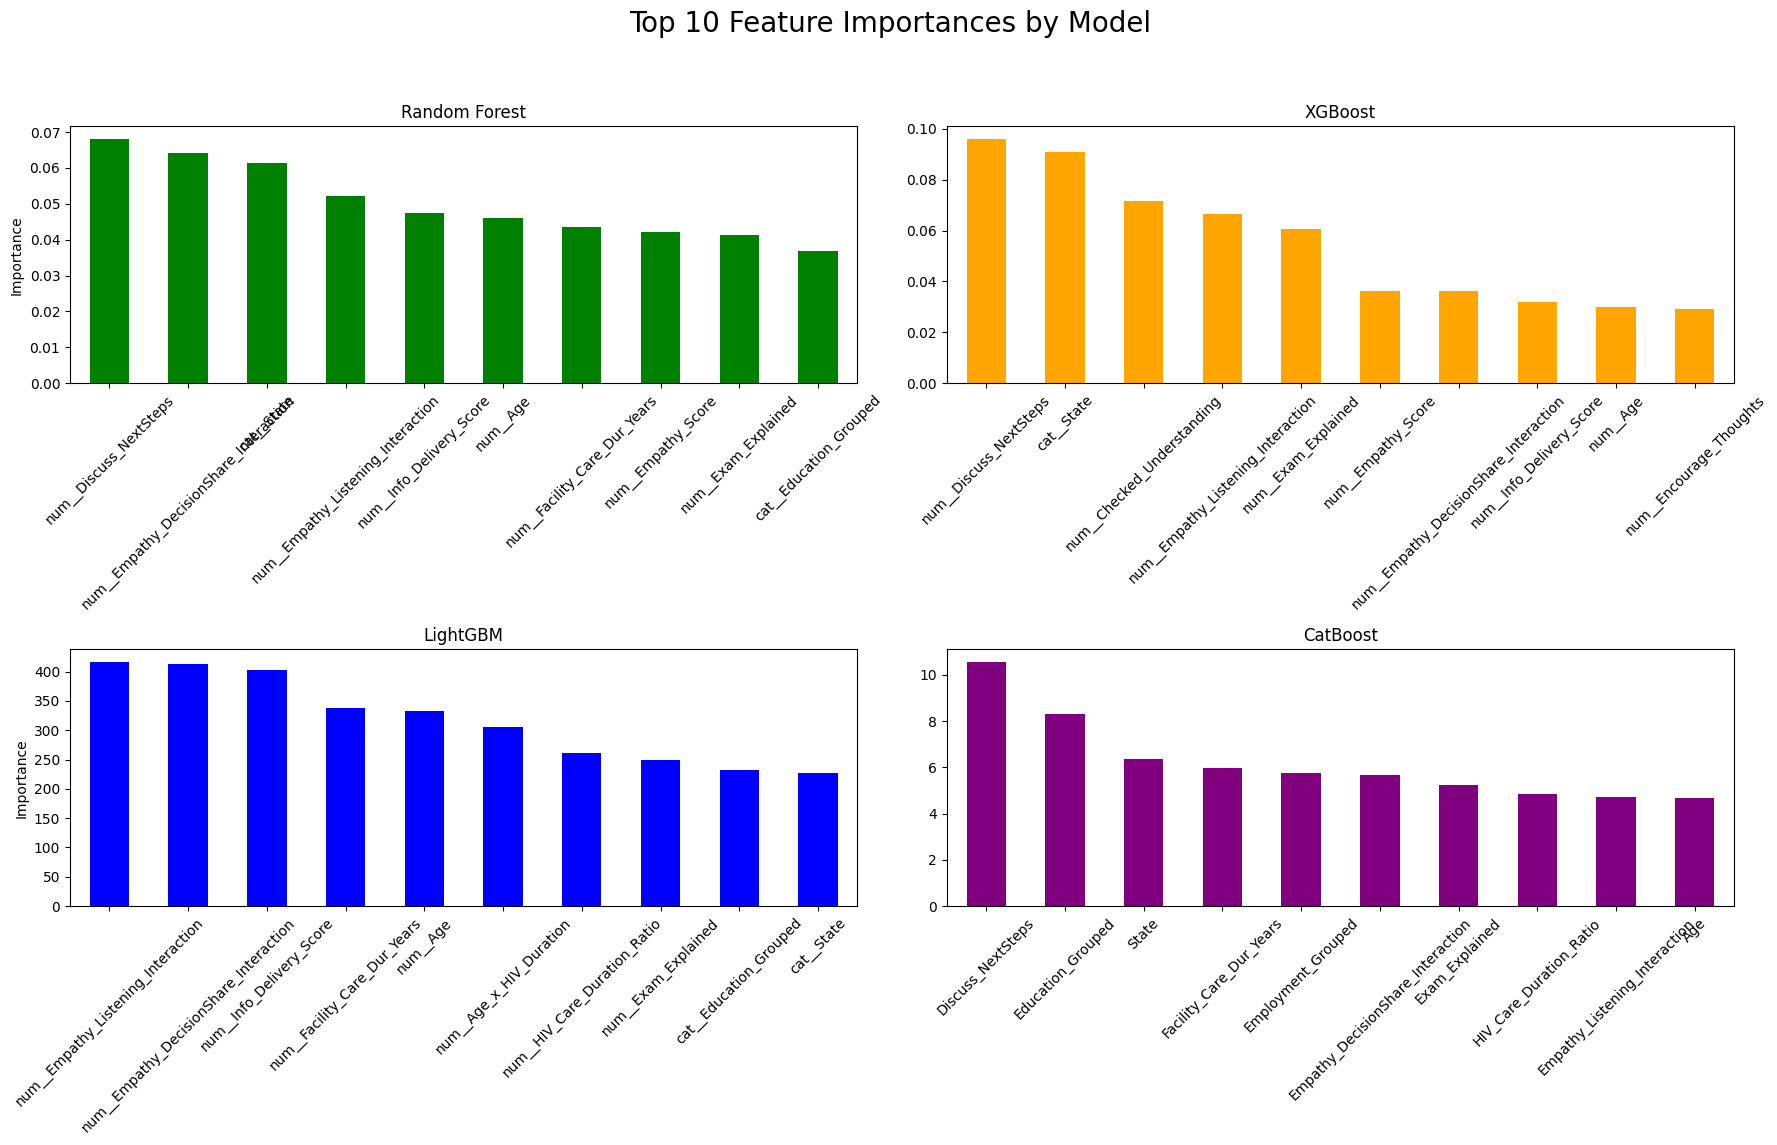

In [ ]:
# --------------------------------------------
#@title ✅ Plotting all feature importances
# -------------------------------------------

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Top 10 Feature Importances by Model', fontsize=20)

# Random Forest
top_10_rf.plot(kind='bar', ax=axes[0, 0], color='green')
axes[0, 0].set_title('Random Forest')
axes[0, 0].set_ylabel('Importance')
axes[0, 0].tick_params(axis='x', rotation=45)

# XGBoost
top_10_xgb.plot(kind='bar', ax=axes[0, 1], color='orange')
axes[0, 1].set_title('XGBoost')
axes[0, 1].tick_params(axis='x', rotation=45)

# LightGBM
top_10_lgbm.plot(kind='bar', ax=axes[1, 0], color='blue')
axes[1, 0].set_title('LightGBM')
axes[1, 0].set_ylabel('Importance')
axes[1, 0].tick_params(axis='x', rotation=45)

# CatBoost
top_10_cat.plot(kind='bar', ax=axes[1, 1], color='purple')
axes[1, 1].set_title('CatBoost')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# ------------------------------------------------------------------------------
#@title ✅ Select and save the best model with multiple-metric weighted scoring
# ------------------------------------------------------------------------------


# Define weights for your metrics
# e.g., prioritize F1 more than Log Loss
weight_f1 = 0.8
weight_logloss = 0.2

# Compute scores on test set for each model
model_scores = {}

# Random Forest
f1_rf = f1_score(y_test_encoded, y_pred_rf, average='weighted')
logloss_rf = log_loss(y_test_encoded, y_proba_rf)
model_scores['RandomForest'] = {'f1': f1_rf, 'logloss': logloss_rf}

# XGBoost
f1_xgb = f1_score(y_test_encoded, y_pred_xgb, average='weighted')
logloss_xgb = log_loss(y_test_encoded, y_proba_xgb)
model_scores['XGBoost'] = {'f1': f1_xgb, 'logloss': logloss_xgb}

# LightGBM
f1_lgbm = f1_score(y_test_encoded, y_pred_lgbm, average='weighted')
logloss_lgbm = log_loss(y_test_encoded, y_proba_lgbm)
model_scores['LightGBM'] = {'f1': f1_lgbm, 'logloss': logloss_lgbm}

# CatBoost (uses raw X_test and y_test)
f1_cat = f1_score(y_test, y_pred_catboost, average='weighted')
logloss_cat = log_loss(y_test, y_proba_catboost)
model_scores['CatBoost'] = {'f1': f1_cat, 'logloss': logloss_cat}

# Compute final weighted scores
final_scores = {}
for model_name, metrics in model_scores.items():
    final_score = (weight_f1 * metrics['f1']) - (weight_logloss * metrics['logloss'])
    final_scores[model_name] = final_score

# Select best model
best_model_name = max(final_scores, key=final_scores.get)
best_model_instance = {
    'RandomForest': best_rf_model,
    'XGBoost': best_xgb_model,
    'LightGBM': best_lgbm_model,
    'CatBoost': best_catboost_model
}[best_model_name]

# Save the best model
models_dir = 'trained_models'
os.makedirs(models_dir, exist_ok=True)
filename = os.path.join(models_dir, f'{best_model_name}_best_tuned_model.joblib')
joblib.dump(best_model_instance, filename)

# Display results
print("\n📊 Model Evaluation Summary (F1_weighted | Log Loss | Weighted Score):")
for model, scores in model_scores.items():
    final_score = final_scores[model]
    print(f"{model}: F1={scores['f1']:.4f}, LogLoss={scores['logloss']:.4f}, CombinedScore={final_score:.4f}")

print(f"\n🏆 Best Model: {best_model_name} (Saved to {filename})")


📊 Model Evaluation Summary (F1_weighted | Log Loss | Weighted Score):
RandomForest: F1=0.8895, LogLoss=0.5124, CombinedScore=0.6091
XGBoost: F1=0.8693, LogLoss=0.2943, CombinedScore=0.6366
LightGBM: F1=0.8802, LogLoss=0.2993, CombinedScore=0.6443
CatBoost: F1=0.8796, LogLoss=0.2886, CombinedScore=0.6459

🏆 Best Model: CatBoost (Saved to trained_models/CatBoost_best_tuned_model.joblib)


In [ ]:
# --------------------------------------------
#@title ✅ SHAP + EXPLANATION PIPELINE (CATBOOST ONLY)
# --------------------------------------------

try:
    # Attempt to retrieve the API key from Colab secrets
    openrouter_api_key = userdata.get('SATISFACTION_APP_KEY')
    if not openrouter_api_key:
        raise ValueError("SATISFACTION_APP_KEY not found in Colab secrets or is empty.")
except Exception as e:
    print(f"Error retrieving API key from Colab secrets: {e}")
    print("Please ensure you have added 'SATISFACTION_APP_KEY' to Colab secrets and enabled notebook access.")
    # Fallback for local testing or if Colab secrets are not used,
    # though for production, environment variables are preferred.
    # For demonstration, you might temporarily hardcode a valid key IF you understand the security implications.
    openrouter_api_key = 'YOUR_ACTUAL_OPENROUTER_API_KEY_HERE_IF_NOT_USING_COLAB_SECRETS' # Replace with your actual key if not using Colab secrets

label_map = {
    0: 'Very Dissatisfied',
    1: 'Dissatisfied',
    2: 'Neutral',
    3: 'Satisfied',
    4: 'Very Satisfied'
}

logs_df = pd.DataFrame(columns=[
    'instance_idx', 'prediction', 'confidence', 'top_features',
    'reason', 'suggestions', 'genai_explanation'
])

# New rule function for Overall Client Satisfaction
def rule_overall_client_satisfaction(shap_scores, instance_data):
    # Factors Positively Influencing Client Satisfaction:
    # Provider Attitude and Communication (implied by Empathy_Score, Listening_Score)
    # Differentiated Service Delivery (DSD) - assuming this is reflected in other features like wait times (if available) or service efficiency
    # Socio-Economic Factors: Employment_Grouped, Monthly Income_log
    # Treatment Complexity: Treatment Regimen (second or third-line ART)

    # Factors Negatively Influencing Client Satisfaction:
    # Lack of Participatory Care: Decision_Share_Score
    # Poor Provider Attitude: (implied by Empathy_Score, Listening_Score)
    # Family and Treatment Duration: Family_Setting (polygamous), Treatment_Duration_Years (if available)
    # Structural and Financial Barriers: Fears of ART stockouts, fragmented services (these might need more direct features or be inferred)

    # Thresholds for 'low' and 'high' might need to be adjusted based on data distribution
    # This rule will return True if there's a significant positive or negative influence

    reasons = []
    suggestions = []

    # Positive factors (checking for their presence or high scores)
    if shap_scores.get('Empathy_Score', 3) >= 3.5:
        reasons.append("High Empathy Score contributing to satisfaction.")
        suggestions.append("Maintain strong empathetic communication.")
    if shap_scores.get('Listening_Score', 3) >= 3.5:
        reasons.append("High Listening Score indicating good provider listening.")
        suggestions.append("Continue active listening techniques.")

    # Check for DSD-related positive influences (if DSD features exist in instance_data)
    # if instance_data.get('Reduced_Wait_Times', False):
    #     reasons.append("Presence of Differentiated Service Delivery (e.g., reduced wait times) enhanced satisfaction.")
    #     suggestions.append("Expand DSD models where applicable.")
    # if instance_data.get('Monthly_Income_Grouped') in ['Moderate', 'High']:
    #     reasons.append("Moderate to high monthly income positively impacted satisfaction.")
    #     suggestions.append("Consider socio-economic factors in care planning.")
    # if instance_data.get('Treatment_Regimen') in ['Second-line ART', 'Third-line ART']:
    #     reasons.append("More complex ART regimen (second/third-line) associated with higher satisfaction, likely due to tailored support.")
    #     suggestions.append("Ensure robust support systems for clients on complex regimens.")

    # Negative factors (checking for their presence or low scores)
    if shap_scores.get('Decision_Share_Score', 3) < 2.5:
        reasons.append("Lack of participatory care (low decision sharing) negatively impacted satisfaction.")
        suggestions.append("Improve patient engagement in healthcare decisions.")

    if shap_scores.get('Empathy_Score', 3) < 2.5:
        reasons.append("Poor provider attitude (low empathy) negatively impacted satisfaction.")
        suggestions.append("Enhance provider's empathetic communication and attitude training.")
    if shap_scores.get('Listening_Score', 3) < 2.5:
        reasons.append("Poor provider listening negatively impacted satisfaction.")
        suggestions.append("Train providers on active listening techniques.")

    if instance_data.get('Family_Setting') == 'Polygamous':
        reasons.append("Client from a polygamous family setting associated with lower satisfaction.")
        suggestions.append("Provide targeted support for clients from polygamous families.")
    # if instance_data.get('Treatment_Duration_Years', 0) >= 4 and instance_data.get('Treatment_Duration_Years', 0) <= 7:
    #     reasons.append("Longer treatment duration (4-7 years) associated with reduced satisfaction, possibly due to burnout.")
    #     suggestions.append("Implement strategies to mitigate burnout for long-term clients.")
    # if instance_data.get('Fear_ART_Stockouts', False):
    #     reasons.append("Fear of ART stockouts caused anxiety and lowered satisfaction.")
    #     suggestions.append("Address concerns about medication supply chain stability.")
    # if instance_data.get('Fragmented_Services_Issue', False):
    #     reasons.append("Inconvenience of fragmented services negatively impacted satisfaction.")
    #     suggestions.append("Streamline service delivery processes for client convenience.")

    return len(reasons) > 0, reasons, suggestions # Return True if any reason is found, along with reasons and suggestions

RULES = [
    # General rules that only depend on shap_scores.
    # The third element is now a tuple: (rule_function, expects_instance_data_bool)
    # expects_instance_data_bool is True for rule_overall_client_satisfaction
    # and False for the other rules.
    ('Empathy was a key factor', "Focus on cultivating supportive and warm provider relationships.", (lambda s: s.get('Empathy_Score', 3) < 2.5 or s.get('Empathy_Score', 3) >= 3.5, False)),
    ('Decision-sharing was a key factor', "Improve client involvement in healthcare decisions.", (lambda s: s.get('Decision_Share_Score', 3) < 2.5, False)),
    ('Listening was a key factor', "Enhance provider active listening techniques.", (lambda s: s.get('Listening_Score', 3) < 2.5 or s.get('Listening_Score', 3) >= 3.5, False)),
    # New rule for overall client satisfaction, which requires instance_data
    ('Overall Client Satisfaction influenced by multiple factors',
     "Address a combination of provider communication, service delivery, socio-economic factors, treatment complexity, participatory care, family dynamics, treatment duration, and structural/financial barriers.",
     (rule_overall_client_satisfaction, True))
]

def enforce_categorical_dtypes(df, categorical_cols):
    for col in categorical_cols:
        df[col] = df[col].astype('category')
    return df

def get_shap_explainer(model, background_data):
    return shap.TreeExplainer(model)

def deepseek_generate_explanation(prediction, confidence, top_features, reasons, suggestions, openrouter_api_key):
    prompt = f"""
    You are an AI assistant helping a healthcare team understand why a specific HIV client was predicted to be '{prediction}' with {confidence}% confidence.

    Top contributing factors:
    {json.dumps(top_features, indent=2)}

    Rule-based issues/influences:
    {reasons}

    Suggestions for improvement/reinforcement:
    {suggestions}

    Based on the article summary "Journey to Sustainability: Enhancing HIV Person Centered Client Care and Life-saving Programming," consider the following factors when generating the explanation:
    - **Positive Influences:** Respectful provider interactions (empathy, communication in preferred language), Differentiated Service Delivery (reduced wait times, multi-month dispensing, fast-track refill), socio-economic factors (unemployed/part-time/self-employed, moderate to high income), and clients on more complex second or third-line ART regimens.
    - **Negative Influences:** Lack of participatory care, poor provider attitude, polygamous family settings, longer treatment duration (4-7 years), anxiety/emotional distress due to fears of ART stockouts, and inconvenience of fragmented services.

    Write a concise and actionable explanation for clinical quality improvement, clearly articulating what led to the predicted satisfaction level and providing specific recommendations.
    """
    headers = {
        "Authorization": f"Bearer {openrouter_api_key}",
        "Content-Type": "application/json",
        #"HTTP-Referer": "https://your-site.com",
        #"X-Title": "HIV Satisfaction Model"
    }
    body = {
        "model": "tngtech/deepseek-r1t2-chimera:free",
        "messages": [{"role": "user", "content": prompt}]
    }
    try:
        response = requests.post("https://openrouter.ai/api/v1/chat/completions",
                                headers=headers, data=json.dumps(body))
        if response.status_code == 200:
            return response.json()['choices'][0]['message']['content']
        else:
            return "LLM error: " + response.text
    except Exception as e:
        return f"Exception: {e}"

def explain_catboost_prediction(instance_idx, model, X_test, background_data, categorical_cols, openrouter_api_key):
    global logs_df

    X_test = enforce_categorical_dtypes(X_test.copy(), categorical_cols)
    background_data = enforce_categorical_dtypes(background_data.copy(), categorical_cols)
    explainer = get_shap_explainer(model, background_data)
    instance = X_test.iloc[instance_idx:instance_idx+1]
    shap_vals = explainer.shap_values(instance)
    preds = model.predict_proba(instance)[0]
    pred_class = model.predict(instance) # This returns a numpy array, e.g., array([4])

    confidence_val = round(float(np.max(preds)) * 100, 1)
    confidence = f"{confidence_val}%" # now a clean string


    shap_vals_row = shap_vals[np.argmax(preds)][0] if isinstance(shap_vals, list) else shap_vals[0]
    shap_dict = dict(zip(X_test.columns, shap_vals_row.flatten()))
    top_features = dict(sorted(shap_dict.items(), key=lambda x: abs(x[1]), reverse=True)[:3])
    top_features = {k: round(float(v), 1) for k, v in top_features.items()} # format nicely


    shap_scores = {
        'Empathy_Score': instance['Empathy_Score'].iloc[0],
        'Decision_Share_Score': instance['Decision_Share_Score'].iloc[0],
        'Listening_Score': instance['Listening_Score'].iloc[0],
        # Add other relevant scores if they exist and are numeric
    }

    # Extract the actual instance data for the rule, especially for categorical features
    instance_data = instance.iloc[0].to_dict()

    reasons, suggestions = [], []
    for reason_text, suggestion_text, rule_tuple in RULES:
        rule_fn, expects_instance_data = rule_tuple # Unpack the tuple

        if expects_instance_data: # If the rule expects both shap_scores and instance_data
            is_triggered, rule_reasons, rule_suggestions = rule_fn(shap_scores, instance_data)
            if is_triggered:
                reasons.extend(rule_reasons)
                suggestions.extend(rule_suggestions)
        else: # For rules that only need shap_scores
            if rule_fn(shap_scores):
                reasons.append(reason_text)
                suggestions.append(suggestion_text)

    # FIX IS HERE: Convert the numpy array to a single integer
    mapped_pred = pred_class # Use label_map for the prediction output
    # or simply: mapped_pred = label_map[pred_class.item()] if you are sure it's a scalar array


    explanation_text = deepseek_generate_explanation(
        mapped_pred, confidence, top_features, reasons, suggestions,
        openrouter_api_key=openrouter_api_key
    )

    log_entry = {
        'instance_idx': instance_idx,
        'prediction': mapped_pred,
        'confidence': confidence,
        'top_features': top_features,
        'reason': "; ".join(reasons),
        'suggestions': "; ".join(suggestions),
        'genai_explanation': explanation_text
    }

    logs_df = pd.concat([logs_df, pd.DataFrame([log_entry])], ignore_index=True)
    return log_entry

def run_explanations_for_catboost(model, X_test_catboost, categorical_cols, max_instances=5):
    print(f"\n🔎 Explaining top {max_instances} instances with SHAP + DeepSeek...")
    background_data = X_test_catboost.sample(n=min(100, len(X_test_catboost)), random_state=42)
    for idx in range(min(max_instances, len(X_test_catboost))):
        log_entry = explain_catboost_prediction(idx, model, X_test_catboost, background_data, categorical_cols, openrouter_api_key=openrouter_api_key)
        print(f"\n🧾 Instance {idx} explanation:")
        print(log_entry)
    print("\n✅ Completed explanation batch.")
    print("\n📋 Explanation Logs (Top 5):")
    print(logs_df.head())

# --------------------------------------------
# ✅ CALL FUNCTION TO GENERATE OUTPUT
# --------------------------------------------

cat_features = [
     'Education_Grouped',
    'State', 'Employment_Grouped'
]

run_explanations_for_catboost(
    model=best_catboost_model,
    X_test_catboost=X_test_catboost,
    categorical_cols=cat_features,
    max_instances=2
)


🔎 Explaining top 2 instances with SHAP + DeepSeek...

🧾 Instance 0 explanation:
{'instance_idx': 0, 'prediction': array([['Satisfied']], dtype=object), 'confidence': '91.8%', 'top_features': {'Empathy_Score': -0.5, 'Num of Children': 0.4, 'HIV_Care_Duration_Ratio': 0.4}, 'reason': 'Empathy was a key factor; Listening was a key factor; High Empathy Score contributing to satisfaction.; High Listening Score indicating good provider listening.', 'suggestions': 'Focus on cultivating supportive and warm provider relationships.; Enhance provider active listening techniques.; Maintain strong empathetic communication.; Continue active listening techniques.', 'genai_explanation': '\n\n### **Predicted Satisfaction Explanation & Actionable Recommendations**  \n**Confidence:** 91.8% ("Satisfied")  \n**Key Drivers of Satisfaction:**  \n1. **Empathetic Provider Interactions** (Top Influence): Despite the negative coefficient (-0.5), the rule-based analysis confirms high empathy and active listening 